# Design local geary c function in R

Author: *Ali Syed* and *Sihan Mao*

## 1. Setup

In [16]:
# try airbnb data for local moran and local geary comparison
# import packages
library(sf)          
library(spdep)
library(dplyr)
library(tidyverse)
library(stringr)
library(rgeos)
library(rgdal)
library(lubridate)
library(tmap)

In [4]:
#set the working directory 
setwd("D:/Auguste/UChicago/2018-2019/2019spring/GIS III//final project//airbnb")

Sample data: Chicago Airbnb data in 2015

In [5]:
airbnb <- read_sf('airbnb_Chicago 2015.shp', quiet = FALSE)

Reading layer `airbnb_Chicago 2015' from data source `D:\Auguste\UChicago\2018-2019\2019spring\GIS III\final project\airbnb\airbnb_Chicago 2015.shp' using driver `ESRI Shapefile'
Simple feature collection with 77 features and 20 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -87.94011 ymin: 41.64454 xmax: -87.52414 ymax: 42.02304
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs


### 1.1 Sample Data Introduction

**Dataset Description**: The dataset is the test dataset of tutorial for calculating local Geary c in R. The test requires a continuous variable as the attribute of polygons. The dataset includes Airbnb rents and boundaries of community areas in Chicago.

**Type**: Polygon shapefile; Observations: 77; Variables: 3 

**Variables to be included**: 

- *community* - name of community area 
- *AREAID* – ID number associated with community area 
- *price_pp* – price per person of Airbnb

**Source**: 

1): GeoDa Center (https://geodacenter.github.io/data-and-lab//airbnb_Chicago-2015/), based on data from Chicago Data Portal (https://data.cityofchicago.org/);

2): Inside Airbnb (http://insideairbnb.com/get-the-data.html). 


## 2. Create neighbors and weights

In [6]:
# Calculate neighbours
nb2 <- poly2nb(airbnb, queen = FALSE)
nb2

listw2 <- nb2listw(nb2)

local2 <- localmoran(x = airbnb$income_pc, listw = nb2listw(nb2, style = "W"))

Neighbour list object:
Number of regions: 77 
Number of nonzero links: 370 
Percentage nonzero weights: 6.240513 
Average number of links: 4.805195 

## 3. Local Geary C 

Calculate global geary c from local geary c

- Local Geary c:

$$LG_i = \sum_{j=1}^{n}w_{ij}(x_i-x_j)^2$$

### 3.1 Calculate local Geary c

In [9]:
## create an empty vector for local geary c
ci2 = vector("double")

## calculate local geary c 
for (i in 1:(length(airbnb$income_pc))) {
  ci2[i] = sum((airbnb$income_pc[i] - airbnb$income_pc[nb2[[i]]])^2)/length(nb2[[i]])
}

summary(ci2)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
4.910e+06 3.689e+07 8.253e+07 1.726e+08 1.993e+08 1.208e+09 

**ci2** is the local geary c statistic created for each polygon.

### 3.2 Visualize local Geary c

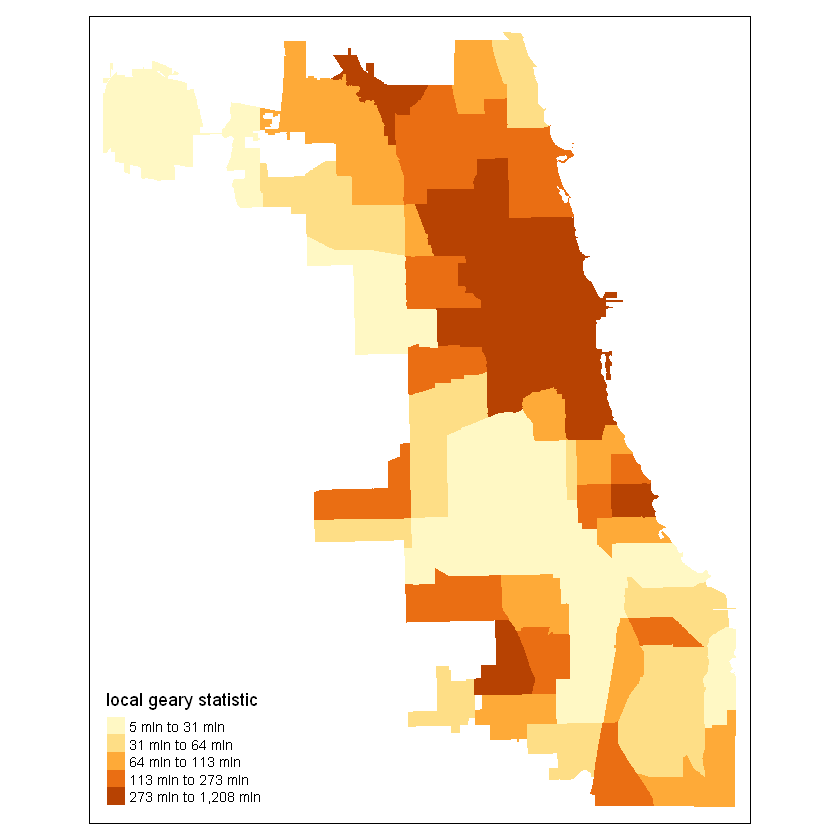

In [15]:
gearymap <- cbind(airbnb, ci2)
tm_shape(gearymap) + tm_fill(col = "ci2", style = "quantile", title = "local geary statistic")

### 3.3 Verify local Gear c with global Geary

- Global Geary c: 

$$C = \frac{(n-1)}{2\sum_{i=1}^{n}\sum_{j=1}^{n}w_{ij}} \frac{\sum_{i=1}^{n}\sum_{j=1}^{n}w_{ij}(x_i-x_j)^2}{\sum_{i=1}^{n}(x_i - \bar{x})^2}$$

In [22]:
## calculate global geary c
sum(ci2)/(var(airbnb$income_pc)*2*77)

[1] 0.369054

Compare with global geary c from function geary.test

In [28]:
# compare with geary c function
geary.test(airbnb$income_pc,listw2)


	Geary C test under randomisation

data:  airbnb$income_pc 
weights: listw2 

Geary C statistic standard deviate = 7.4298, p-value = 5.439e-14
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.369053984       1.000000000       0.007211626 


Manually calculated global geary c is consistent with the result from geary test function, which indicates that the computed local geary c is correct. 

## 4. Permutation and Significance

Calculating local Geary c is not the last step of spatial autocorrelation analysis. *"An important methodological issue associated with the local spatial autocorrelation statistics is the selection of the p-value cut-off to properly reflect the desired Type I error."*$^1$

Permutation is required to simulate spatial randomness in order to generate plausible p-values for local Gear c statistics. [ADD EXPLANATION]

### 4.1 Conditional Permutations

*Still working on creating permutation functions from python community*

### 4.2 Global Moran's I

Variable "Ii" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.


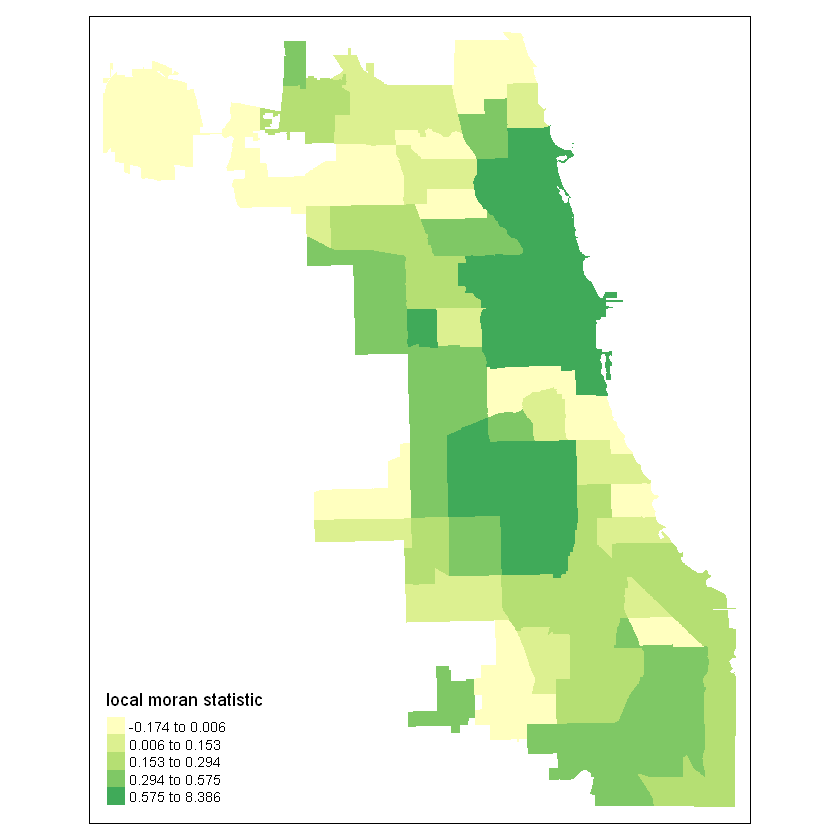

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.03013 -0.03013 -0.03013 -0.03013 -0.03013 -0.03013 

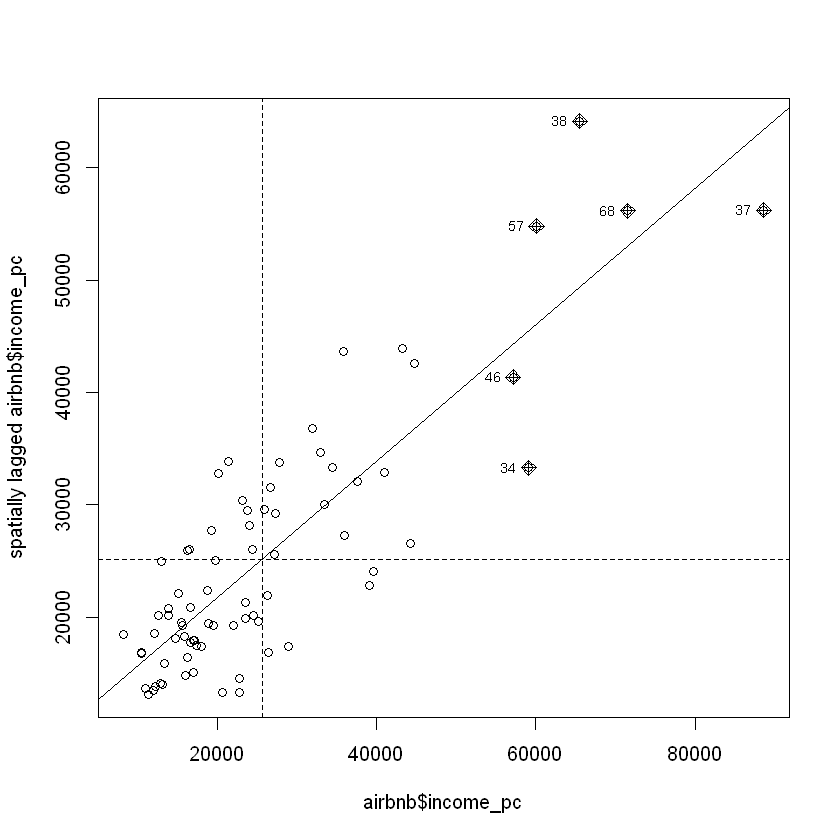

In [24]:
moranmap <- cbind(airbnb, local2)
tm_shape(moranmap) + tm_fill(col = "Ii", style = "quantile", title = "local moran statistic")

moran <- moran.plot(airbnb$income_pc, listw = nb2listw(nb2, style = "W"))
summary(local2[1])

#### 4.3 LISA map with significance 

In [ ]:
### create LISA map with significance 
### to create LISA cluster map ### 
quadrant <- vector(mode="numeric",length=nrow(local))

# centers the variable of interest around its mean
mean_income <- airbnb$income_pc - mean(airbnb$income_pc)     

# centers the local Moran's around the mean
m.local2 <- local2[,1] - mean(local2[,1])    

# significance threshold
signif <- 0.05 

# builds a data quadrant
quadrant[mean_income >0 & m.local2>0] <- 4  
quadrant[mean_income <0 & m.local2<0] <- 1      
quadrant[mean_income <0 & m.local2>0] <- 2
quadrant[mean_income >0 & m.local2<0] <- 3
quadrant[local2[,5]>signif] <- 0   

# plot in r
brks <- c(0,1,2,3,4)
colors <- c("white","blue",rgb(0,0,1,alpha=0.4),rgb(1,0,0,alpha=0.4),"red")
plot(airbnb[0], border="lightgray",col=colors[findInterval(quadrant,brks,all.inside=FALSE)])
box()
legend("bottomleft",legend=c("insignificant","low-low","low-high","high-low","high-high"),
       fill=colors,bty="n")

### 4.4 Match $LG_I$ with small deviations to local morans' I quadrent

*Need to establish on the function of permutation in order to filter out significant polygons*. 

## 5. Citation

1. Luc Anselin, "Local Spatial Autocorrelation: Univariate Local Statistics", *Center for Spatial Data Science at University of Chicago.* 